In [1]:
from fastai.structured import *
from fastai.column_data import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import pickle

In [2]:
# lets load the data
df = pd.read_csv('course_ratings.csv')

In [3]:
#lets remove high rating rows
joined = df.drop(df[df['rating'] > 5].index)

In [4]:
# lets define catigorical vars
cat_vars = ['user','course','category','job','institution','state']
#coninuous vars
cont_vars = ['rating']

# df length
n = len(df)

# test percentage
testp = n*.2

#lets update features, categoricial should be category and continuous should be float32
for v in cat_vars: 
    joined[v] = joined[v].astype('category').cat.as_ordered()
    
for v in cont_vars:
    joined[v] = joined[v].fillna(0).astype('float32')

In [5]:
# we have to convert all category variables into contiguous ones and save the look up table
lookup_table = {}
for c in cat_vars:
    uq = joined[c].unique()
    col2idx =  {o:i for i,o in enumerate(sorted(uq))}
    lookup_table[c] = col2idx
    joined[c] = joined[c].apply(lambda x: col2idx[x])

In [6]:
#lets save the mapper for later use
with open('models/data/lookup_table', 'wb') as fp:
    pickle.dump(lookup_table, fp)

In [7]:
#lets check lookup table
with open ('models/data/lookup_table', 'rb') as fp:
    lut_load = pickle.load(fp)

#lut_load

In [8]:
# create a test/train set split
joined, joined_test = train_test_split(joined, test_size=0.25)
df = joined.drop('rating', axis=1)
y = joined['rating']
df_test = joined_test.drop('rating', axis=1)

# create a validation set of ids
train_ratio = 0.75
train_size = int(len(df) * train_ratio)
val_idx = list(range(train_size, len(df)))

with open('models/data/val_idx', 'wb') as fp:
    pickle.dump(val_idx, fp)
    
with open('models/data/ratings', 'wb') as fp:
    pickle.dump(y, fp)

In [9]:
#final df , everything is numeric and continguous
with open('models/data/final_df', 'wb') as fp:
    pickle.dump(df, fp)

In [10]:
df.head(10)

,user,course,category,job,institution,state
17798,17218,133,3,42,11,30
59294,49177,54,7,6,9,58
34205,1793,39,7,6,0,30
173990,3642,84,7,6,0,24
114094,25772,4,7,6,0,24
72284,12900,3,1,6,0,35
58299,21790,145,8,6,11,25
52046,14637,146,5,29,0,52
49107,26236,126,7,44,9,57
34002,35054,4,7,6,0,30


In [11]:
#lets build the initial model
md = ColumnarModelData.from_data_frame("models/", val_idx, df, y.astype(np.float32), cat_flds=cat_vars, bs=128, test_df=df_test)

In [12]:
#build embedding matrix, matrices should be 1 bigger then the the number of categorical options to leave room for unknown
cat_sz = [(c, len(joined[c].cat.categories)+1) for c in cat_vars]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
with open('models/data/emb_sizes', 'wb') as fp:
    pickle.dump(emb_szs, fp)

In [13]:
#build the learner, 
# .04 dropout on the embedding matrix
# 1000 and 500 nodes on 2 different layers
# .001 and .01 dropouts
# specifying the range of y (rating) to be 0-5
m = md.get_learner(emb_szs,0 ,0.5, 1, [100,50], [0.5,0.01],y_range=(0,5))

In [14]:
m.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 50]),
                           ('trainable', True),
                           ('nb_params', 2605900)])),
             ('Embedding-2',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 50]),
                           ('trainable', True),
                           ('nb_params', 11000)])),
             ('Embedding-3',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 8]),
                           ('trainable', True),
                           ('nb_params', 120)])),
             ('Embedding-4',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 23]),
                           ('trainable', True),
                           ('nb_params', 1058)])),
             ('Embedding-5',
              OrderedDict([('input_sh

In [15]:
#lets find a learning rate
m.lr_find()

epoch      trn_loss   val_loss                                
    0      1.287841   1.25821   



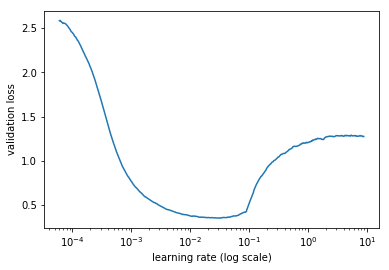

In [16]:
m.sched.plot(100)

In [17]:
lr = 1e-3

In [18]:
# Local
#m.fit(lr, 2, cycle_len=2)

In [19]:
# GPU
# lets fit the model, 50 epochs with restarts
m.fit(lr, 5, cycle_len=2, wds=1e-4)

epoch      trn_loss   val_loss                                
    0      0.267159   0.235792  
    1      0.190746   0.227946                                
    2      0.203919   0.216884                                
    3      0.152977   0.216242                                
    4      0.176249   0.216451                                
    5      0.135027   0.213607                                
    6      0.163399   0.214819                                
    7      0.128918   0.212993                                
    8      0.173032   0.218286                                
    9      0.133155   0.213572                                



[array([0.21357])]

In [20]:
m.save('mdl')

In [21]:
m.load('mdl')

In [22]:
x,y=m.predict_with_targs()

In [23]:
pred_test=m.predict(is_test=True)

In [24]:
joined_test['rating_pred'] = pred_test

In [25]:
joined_test[['rating','rating_pred']].head(10)

,rating,rating_pred
111685,4.59,3.804317
132193,4.18,4.104474
18514,3.69,4.024045
53583,4.35,4.000181
33980,4.38,3.626581
156859,4.55,4.097500
121005,2.85,3.595472
110445,2.86,4.463190
142052,4.50,4.568205
170230,4.23,3.917554


In [26]:
rms = sqrt(mean_squared_error(joined_test['rating'], joined_test['rating_pred']))

In [27]:
# we achieved a root mean squared error of .47
rms

0.4625460633974777

In [28]:
test_record = df_test.iloc[0]

In [29]:
joined_test.iloc[0]

user             38790
course              77
category             3
rating            4.59
job                 42
institution          9
state               30
rating_pred    3.80432
Name: 111685, dtype: object

In [30]:
cat = test_record[cat_vars].values.astype(np.int64)[None]
contin = test_record.drop(cat_vars).values.astype(np.float32)[None]

#Prediction
model = m.model
model.eval()
prediction = to_np(model(V(cat),[]))

In [31]:
prediction[0][0]

3.8043165

In [33]:
#model is ready, need to create simple api and also test with new data since the original was pulled